In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import sys
sys.path.append('../')

from scripts.compute_covariance import compute_covariance

In [2]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)

In [3]:
cl_hi_1=np.load("/home/iloveorcas/MASS_Thesis/HI/cal_hi_cov.npy")
cl_hi = np.transpose(cl_hi_1, (2, 0, 1))
hi_maps= np.load("HI_map_cal.npy")

In [4]:
def bin_spectra(cl, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [5]:
leff, nbins,hi_binned= bin_spectra(cl_hi, 10)
# *_,noise_binned= bin_spectra(cl_noise, 10)
# *_, fgds_binned= bin_spectra(cl_fgds, 10)
# total=hi_maps + noise_maps[:54]
# cl_hat=compute_covariance(total, lmax, almsize, nfreqs)
# *_, chat_binned= bin_spectra(cl_hat, 10)

In [6]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((nbins, nfreqs, nfreqs))
    for l in range (nbins):
        #print(f"Diagonalizing matrix {l}")
        cl_diag[l,:,:]= np.identity(nfreqs)*cl[l,:,:]
    return cl_diag
hi_d= diagonalize_matrices(hi_binned, nfreqs)
#print(hi_d[10])

In [7]:
bins=5

In [8]:
def build_trapezoidal_basis(freqs, bin, top_width=0.5):
    """
    Create trapezoidal basis functions (___/----\___) on frequency grid.
    
    Parameters:
    - freqs: 1D array of frequency bin centers (nf,)
    - n_bins: number of trapezoidal functions (i.e., nq)
    - top_width: fraction of bin width used for the flat top (0 < top_width < 1)

    Returns:
    - phi: shape (n_bins, nf), the basis matrix
    """
    nf = len(freqs)
    vmin, vmax = freqs[0], freqs[-1]
    bin_edges = np.linspace(vmin, vmax, bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]
    flat_top = top_width * bin_width
    slope_width = (1 - top_width) * bin_width / 2  #slope= 1/slope_width

    phi = np.zeros((bin, nf))

    for i in range(bin):
        # Define edges of the trapezoid
        left = bin_edges[i] - slope_width
        start_flat = bin_edges[i]
        end_flat = bin_edges[i + 1]
        right = bin_edges[i + 1] + slope_width

        for j, v in enumerate(freqs):
            if left <= v < start_flat:
                phi[i, j] = (v - left) / slope_width
            elif start_flat <= v <= end_flat:
                phi[i, j] = 1.0
            elif end_flat < v <= right:
                phi[i, j] = (right - v) / slope_width
            else:
                phi[i, j] = 0.0

    return phi


Building the parametric HI model

In [49]:
from itertools import product
from numpy.linalg import lstsq

P, Q = 5,bins-1  #degree
v0=freqs[23]
n=0.5

# Step 1: Extract diagonal
nell, nf, _ = hi_d.shape
C_diag = np.array([np.diag(hi_d[i]) for i in range(nell)])  # shape (nell, nf)

# Step 2: Log coordinates
log_l = np.log10(leff)  # shape (nell,)
log_v = np.log10(freqs[:-1])  # shape (nf,)
scaling = (freqs[:-1] / v0)**(-n)  # shape (nf,)

# Step 3: Build hat-shaped basis
phi = build_trapezoidal_basis(freqs[:-1], bins)  # shape (nq, nf)
# Unnormalized Psi: each row is φ_q(v) * scaling
Psi_unnorm = phi * scaling[None, :]  # shape (nq, nf)

# Normalize across q (rows) for each v (column)
Psi = Psi_unnorm / Psi_unnorm.sum(axis=0, keepdims=True)
print(Psi.shape)# shape (nq, nf)
# Psi = phi * scaling[None, :]              # shape (nq, nf)

# Step 4: Build coeff matrix
basis_terms = list(product(range(P + 1), range(Q + 1))) # all (p, q) pairs (0,0), (0,1), ..., (P,Q)
n_terms = len(basis_terms) # total number of basis functions (P + 1) * (Q + 1)

X = np.zeros((nell * nf, n_terms))# rows = data points, cols = basis terms
y = C_diag.reshape(-1) #flatten target values to shape (nell * nf,)
print(y.shape)
print(len(leff)*nf)

for i, (p, q) in enumerate(basis_terms):
    # Outer product: (nell,) x (nf,) → shape (nell, nf)
    X[:, i] = np.outer(log_l**p, Psi[q,:]).reshape(-1)

# Step 5: Solve least mean squares
a_vec, residuals, rank, s = lstsq(X, y, rcond=471256)
a_vec=a_vec/np.linalg.norm(a_vec)
a_matrix = a_vec.reshape((P + 1, Q + 1))  # shape (P+1, Q+1)
print(a_matrix.shape)
print(a_vec.shape)

# Step 6: Reconstruct the fitted diagonal
C_fit_diag = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_fit_diag +=a_matrix[p, q] * np.outer(log_l**p, Psi[q])

# Step 7: Expand to full (nell, nf, nf) with diagonal only
C_fit = np.zeros((nell, nf, nf))
for i in range(nell):
    np.fill_diagonal(C_fit[i], C_fit_diag[i])


(5, 54)
(4104,)
4104
(6, 5)
(30,)


In [ ]:
def loss(a):
    a_mat = a.reshape((P + 1, Q + 1))  # reshape into coefficient matrix
    C_model = np.zeros((nell, nf))    # predicted covariance diagonal
    for p in range(P + 1):
        for q in range(Q + 1):
            C_model += a_mat[p, q] * np.outer(log_l**p, Psi[q])
    r = ((C_model - C_fit_diag)).reshape(-1)   #/np.linalg.norm(C_fit_diag)).reshape(-1)  # residual
    # r=X @ a - y  # residual vector
    return 0.5* np.dot(r, r)           # MSE

def grad_loss(a):
    a_mat = a.reshape((P + 1, Q + 1))
    C_model = np.zeros((nell, nf))
    for p in range(P + 1):
        for q in range(Q + 1):
            C_model += a_mat[p, q] * np.outer(log_l**p, Psi[q])
    r = (C_model - C_fit_diag)

    grad = np.zeros_like(a_mat)
    for p in range(P + 1):
        log_term = log_l**p  # shape (nell,)
        for q in range(Q + 1):
            psi_term = Psi[q]  # shape (nf,)
            grad[p, q] = np.sum(r * np.outer(log_term, psi_term))
    return grad.reshape(-1)

In [164]:
from numpy.linalg import slogdet, inv

y=(X@a_vec).reshape((nell, nf))
C_y = np.zeros((nell, nf, nf))
for i in range(nell):
    np.fill_diagonal(C_y[i], y[i])
    
# # Example: equal weight for each ell bin
# n_q = np.ones(nbins)  

# # Or: number of modes in each ell bin
# n_q = np.array([sum(2*l + 1 for l in range(nbins)) 
#                 for b in range(nbins)])

def build_C_model(a):
    # a_mat = a.reshape((P + 1, Q + 1))  # reshape into coefficient matrix
    # C_model = np.zeros((nell, nf))    # predicted covariance diagonal
    # for p in range(P + 1):
    #     for q in range(Q + 1):
    #         C_model += a_mat[p, q] * np.outer(log_l**p, Psi[q])
    C_model=(X @a).reshape((nell, nf))
    C_model_full = np.zeros((nell, nf, nf))
    for i in range(nell):
        np.fill_diagonal(C_model_full[i], C_model[i])

    return C_model_full


def smica_loss(a):
    
    loss = 0.0
    C_model = build_C_model(a)
    
    for b in range(nbins):
        C_emp = C_y[b] #+ 1e-3 * np.eye(nfreqs) # empirical HI covariance at that b
        C_mod = C_model[b] #+ 1e-3 * np.eye(nfreqs)

        sign, logdet = slogdet(C_emp @ np.linalg.inv(C_mod))
        # if sign <= 0:
        #     return np.inf  # invalid logdet => reject this parameter set
        trace_term = np.trace(C_emp @ np.linalg.inv(C_mod))
        loss +=  (trace_term - logdet - nfreqs)
    return loss


def jacobian(a):

    C_model = build_C_model(a)  # shape (nell, nf, nf)
    grad = np.zeros((P+1, Q+1))

    for b in range(nbins):
        C_emp = C_y[b]  #+ 1e-3 * np.eye(nfreqs)      # empirical (nf, nf)
        C_mod = C_model[b]  #+ 1e-3 * np.eye(nfreqs)
      # model (nf, nf)
        C_mod_inv = np.linalg.inv(C_mod)

        Delta = C_mod_inv - C_mod_inv @ C_emp @ C_mod_inv  # (nf, nf)

        for p in range(P+1):
            for q in range(Q+1):
                dR = np.zeros_like(C_mod)
                diag_val = (log_l[b]**p) * Psi[q]  # length nf
                np.fill_diagonal(dR, diag_val)
                grad[p, q] += np.trace(Delta @ dR)  # multiply by n_q[b] if needed

    return grad.reshape(-1)



In [165]:
smica_loss(a_vec)

np.float64(0.0)

In [ ]:
a_current = 2* a_vec
alpha = 1e-14
tol_grad=1e-2

for i in range(100000):
    loss_current = smica_loss(a_current)
    grad_current = jacobian(a_current)
    grad_norm = np.linalg.norm(grad_current)
    
    # if grad_norm > 1e3:  # clip gradient norm or scale step
    #     grad_current = grad_current / grad_norm * 1e3
    
    a_current = a_current - alpha * grad_current

    if i % 1000 == 0:
        print(f"Step {i}, loss = {loss_current:.6e}, grad norm = {grad_norm:.3e}")
    if np.linalg.norm(grad_current) < tol_grad:
        print(f"Stopping at iter {i}: gradient small.")
        break



Step 0, loss = 7.926760e+02, grad norm = 8.686e+07
Step 1000, loss = 3.950181e+02, grad norm = 6.912e+06
Step 2000, loss = 3.741726e+02, grad norm = 1.385e+06
Step 3000, loss = 3.565160e+02, grad norm = 1.272e+06
Step 4000, loss = 3.417141e+02, grad norm = 1.161e+06
Step 5000, loss = 3.293976e+02, grad norm = 1.059e+06
Step 6000, loss = 3.191308e+02, grad norm = 9.688e+05
Step 7000, loss = 3.104912e+02, grad norm = 8.918e+05
Step 8000, loss = 3.031152e+02, grad norm = 8.274e+05
Step 9000, loss = 2.967136e+02, grad norm = 7.741e+05
Step 10000, loss = 2.910679e+02, grad norm = 7.298e+05
Step 11000, loss = 2.860170e+02, grad norm = 6.925e+05
Step 12000, loss = 2.814442e+02, grad norm = 6.606e+05
Step 13000, loss = 2.772645e+02, grad norm = 6.329e+05
Step 14000, loss = 2.734150e+02, grad norm = 6.084e+05
Step 15000, loss = 2.698485e+02, grad norm = 5.863e+05
Step 16000, loss = 2.665283e+02, grad norm = 5.663e+05
Step 17000, loss = 2.634255e+02, grad norm = 5.479e+05
Step 18000, loss = 2.60

In [146]:
def is_psd(P, tol=0):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= -tol) 
print("Is model PSD?", is_psd(C_fit))

Is model PSD? True


In [147]:
np.allclose(C_fit,build_C_model(a_vec))

True

In [109]:
np.min(np.linalg.eigvalsh(build_C_model(a_vec)))

np.float64(0.00022614624622632924)

In [ ]:
from scipy.optimize import minimize

res2 = minimize(smica_loss,a_vec,
               jac=jacobian,
               method='CG',
               options={'disp': True, 'maxfun': 600000,'ftol': 1e-8, 'maxls':100000, 'gtol': 1e-8, 'maxiter': 12000}) #, 'maxls':100,'xtol': 1e-15, 'gtol': 1e-15, 'verbose': 2

a_opt2 = res2.x.reshape((P+1, Q+1))

In [155]:
from pprint import pprint

pprint(res2)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -8.171241461241152e-14
        x: [ 1.516e-01  7.698e-02 ... -1.314e-04  5.853e-05]
      nit: 1
      jac: [ 1.678e-01  6.788e-01 ...  1.128e+05  3.073e+05]
     nfev: 837
     njev: 27
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>


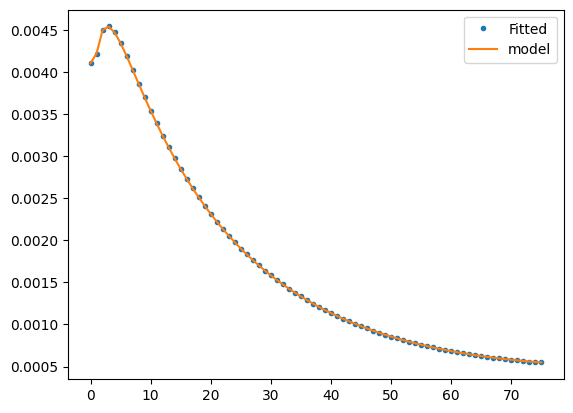

In [156]:
a_smica= a_opt2.reshape((P+1, Q+1))
C_smica= np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_smica += (a_smica[p, q]) * np.outer(log_l**p, Psi[q])



plt.plot( C_smica[:,26], '.',label='Fitted')
plt.plot( C_fit_diag[:,26], label='model')
plt.legend()